# 2022-12-27 Testing Fast atlas
Testing Fast Atlas on the Krios with the K3 since the K2 seemed to have reached its limits

## What ended up happening

- First test with a speed factor of 0.7 with 0.05s frames resulted in 170 second total time with slightly blurry frames. Need to slow down
- With Speed factor of 0.5, it takes 233s

## Function used for acquisition

Here is the testing function that was used to collect the data.

```python
def acquire_fast_atlas_test2(microscope_id):
    import serialem as sem
    from Smartscope.lib.microscope_methods import FastAtlas,make_serpent_pattern_in_mask

    microscope = Microscope.objects.get(pk=microscope_id)
    with TFSSerialemInterface(ip=microscope.serialem_IP,
                              port=microscope.serialem_PORT,
                              directory=microscope.windows_path,
                              scope_path=microscope.scope_path,
                              energyfilter=False,
                              loader_size=microscope.loader_size,
                              frames_directory='X:/testing/') as scope:
        scope.set_atlas_optics(62,100,5)
        sem.SetColumnOrGunValve(1)
        sem.Search()
        X, Y, _, _, pixel_size, _ = sem.ImageProperties('A')
        logger.info(f'Setting atlas for {X}, {Y}, {pixel_size}')
        atlas = FastAtlas(atlas_imsize_x=X,atlas_imsize_y=Y,pixel_size_in_angst=pixel_size*10)
        atlas.generate_tile_mask(atlas_radius_in_um=990)
        atlas.make_stage_pattern(make_serpent_pattern_in_mask)
        sem.SetContinuous('R',1)
        sem.UseContinuousFrames(1)
        sem.StartFrameWaitTimer(-1)
        start_time = time.time()
        time_distances = []
        sem.MoveStageTo(*atlas.stage_movements[0][0])
        
        for ind, m in enumerate(atlas.stage_movements):
            start, end = m
            distance = abs(start[1]-end[1])
            Path(scope.scope_path,'raw','atlas',str(ind)).mkdir(parents=True,exist_ok=True)
            sem.SetFolderForFrames(f'{scope.directory}raw/atlas/{ind}')
            sem.MoveStageTo(*start)
            sem.Record()
            start_movement = time.time()
            logger.info(f'Starting movement {ind} at {start}, moving to {end}')
            sem.Echo(f'Movemement {ind}')
            stage_movement = end - start
            sem.MoveStageWithSpeed(*stage_movement,0.7)
            # sem.WaitForNextFrame()
            sem.StopContinuous()
            movement_elapsed = time.time() - start_movement
            distance = abs(start[1]-end[1])
            logger.info(f'Movement {ind} took {movement_elapsed:.1f} for a distance of {distance}')
            time_distances.append([movement_elapsed,distance])

        sem.SetContinuous('R',0)
        elapsed = time.time() - start_time
        logger.info(f'Finished acquisition in {elapsed:.0f} seconds.')
```


## Structure of the output files

The output atlas directory works as follows

- One directory for each stage movement starting from 0. Each frame/movie is saved in that directory and are numbered in their acquisition number from *_000.tif
- Each movement has a different length so the number of frames permmovement is different.

## Checking the results

In [1]:
import subprocess as sub
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import libtiff
import imutils
from Smartscope.lib.image_manipulations import auto_contrast_sigma
import numpy as np
%matplotlib inline

In [2]:
rootDir = Path('/auto_screening/testing/20221227_atlas2')
binningFactor = 4
sorted(rootDir.iterdir(), key= lambda x: int(x.name))


[PosixPath('/auto_screening/testing/20221227_atlas2/0'),
 PosixPath('/auto_screening/testing/20221227_atlas2/1'),
 PosixPath('/auto_screening/testing/20221227_atlas2/2'),
 PosixPath('/auto_screening/testing/20221227_atlas2/3'),
 PosixPath('/auto_screening/testing/20221227_atlas2/4')]

Pulling from movement 0

In [3]:
movement = rootDir/ '0'
files = sorted(movement.glob('*.tif'), key= lambda x: x.stat().st_ctime)

In [4]:
def read_from_tiff(file):
    tif = libtiff.TIFF.open(file)
    im = tif.read_image()
    shape = np.array(im.shape) / binningFactor
    shape = shape.astype(int)
    # print(f'Before bin: {im.shape}, After bin: {shape}')
    im = imutils.resize(im,shape[1],shape[0])
    im = auto_contrast_sigma(im)
    return im

/home/bouvettej2/Smartscope-dev/Smartscope/lib/image_manipulations.py:86: RuntimeWarning: divide by zero encountered in true_divide
  img = (img.astype('float32') - min_side) / (max_side)
/home/bouvettej2/Smartscope-dev/Smartscope/lib/image_manipulations.py:86: RuntimeWarning: invalid value encountered in true_divide
  img = (img.astype('float32') - min_side) / (max_side)


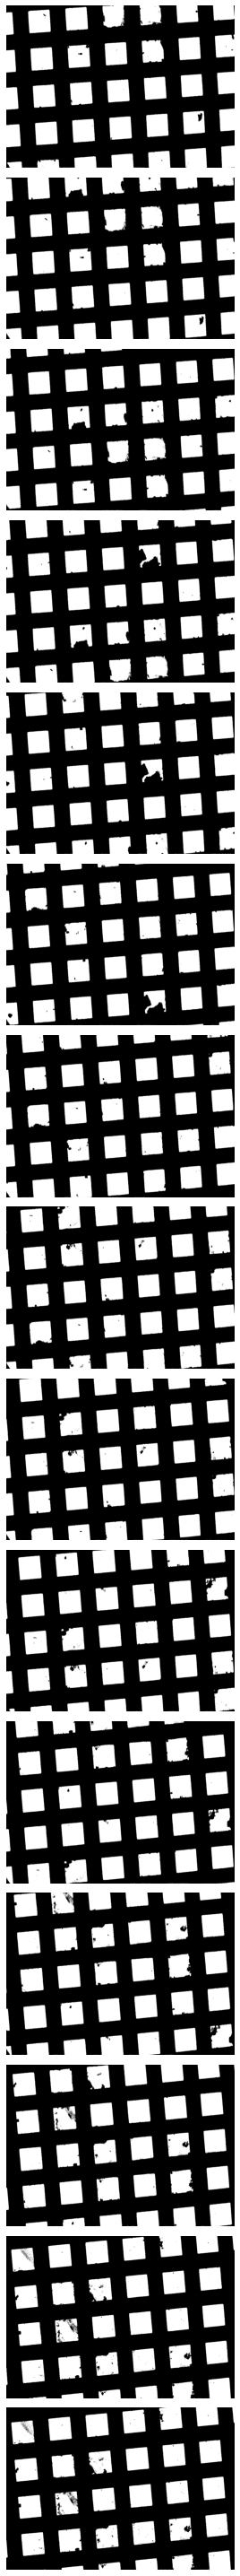

In [5]:
fig, axs = plt.subplots(len(files), 1)
fig.set_size_inches(6,40)
fig.set_tight_layout(True)

for i,file in enumerate(files):
    
    im = read_from_tiff(file)
    axs[i].imshow(im,cmap='gray')
    axs[i].axis('off')


## Extracting metadata and build initial stitching

In [6]:
all_mdocs = []
all_images = []
for movement in sorted(rootDir.iterdir(), key= lambda x: int(x.name)):
    all_mdocs += sorted(movement.glob('*.mdoc'), key= lambda x: x.stat().st_ctime)
    all_images += sorted(movement.glob('*.tif'), key= lambda x: x.stat().st_ctime)

In [7]:
from Smartscope.lib.generic_position import parse_mdoc
import pandas as pd
for i,mdoc in enumerate(all_mdocs):
    mdoc = parse_mdoc(mdoc, movie=True)
    if i == 0:
        all_meta = mdoc
        continue
    all_meta = pd.concat([all_meta, mdoc], ignore_index=True, axis=0)

In [8]:
from Smartscope.lib.transformations import rotate_axis
import numpy as np
def apply_axis_rotation(line):
    return rotate_axis(np.array(line.StagePosition) /(line.PixelSpacing/10_000), line.RotationAngle)
all_meta['pixelStagePosition'] = all_meta.apply(apply_axis_rotation, axis=1)

In [9]:
pixel_positions = np.array(all_meta.pixelStagePosition.to_list())

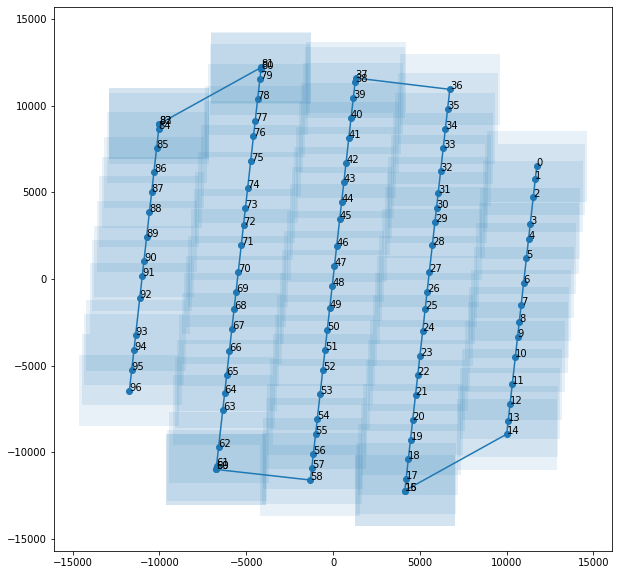

In [15]:
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.plot(pixel_positions[:,0],pixel_positions[:,1],marker='o')
for i,tile in all_meta.iterrows():
    patch = Rectangle(tile.pixelStagePosition - np.array(tile.UncroppedSize)//2,*tile.UncroppedSize,alpha=0.2)
    ax.add_patch(patch)
    ax.text(*tile.pixelStagePosition,str(i))

In [16]:
shape = np.abs(np.array(all_meta.iloc[0].UncroppedSize))
start_pos = (pixel_positions - shape/2) // binningFactor
min_x_y= np.min(np.min(np.concatenate((start_pos)),axis=0))
start_pos-=min_x_y
end_pos = start_pos + shape // binningFactor 
final_shape=np.max(end_pos, axis=0)

In [12]:
final = np.zeros((int(final_shape[1]),int(final_shape[0])),dtype=np.int8)

In [13]:
for ind, (tile, end, file) in enumerate(zip(start_pos,end_pos, all_images)):
    im = read_from_tiff(file)
    # im = np.flip(im,axis=0)
    tile = tile.astype(int)
    end = end.astype(int)
    final[tile[1]:end[1],tile[0]:end[0]] = final[tile[1]:end[1],tile[0]:end[0]] + im*0.1
    # final[tile[1]:end[1],tile[0]:end[0]] = im

/home/bouvettej2/Smartscope-dev/Smartscope/lib/image_manipulations.py:86: RuntimeWarning: divide by zero encountered in true_divide
  img = (img.astype('float32') - min_side) / (max_side)
/home/bouvettej2/Smartscope-dev/Smartscope/lib/image_manipulations.py:86: RuntimeWarning: invalid value encountered in true_divide
  img = (img.astype('float32') - min_side) / (max_side)


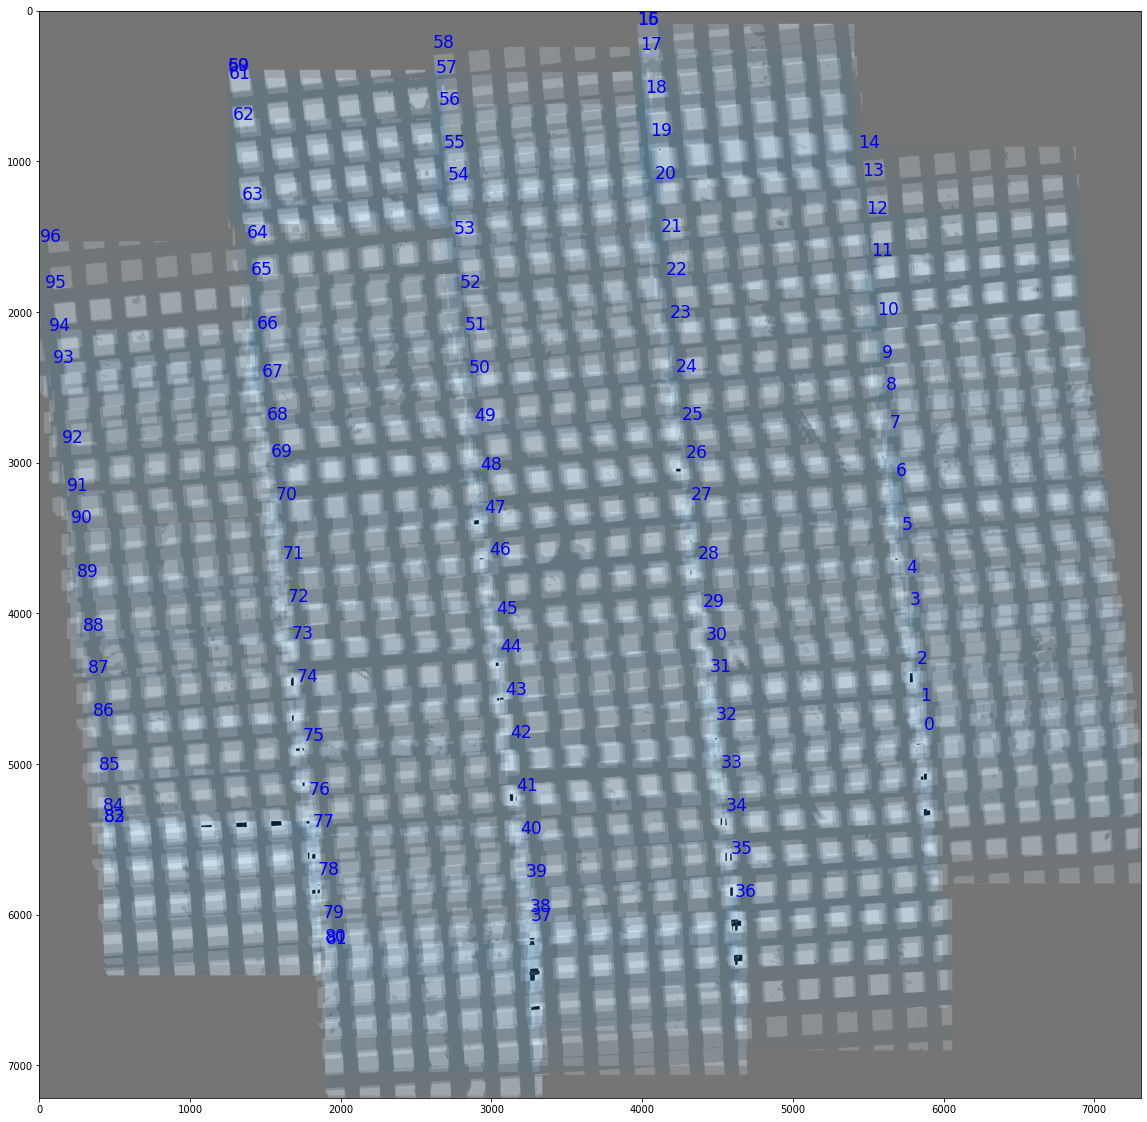

In [17]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)
ax.imshow(final, cmap='gray')
for i,(st,ed) in enumerate(zip(start_pos,end_pos)):
    ax.text(*st,str(i),size='xx-large',color='blue')
    patch = Rectangle(st,*ed-st,alpha=0.05)
    ax.add_patch(patch)

The stitching is not good. The value of stage position seem to be recorded at the start of the frame and then theres a delay for the image to be recorded. Sometimes, the delay is very long and lead to missing tiles along the movement.